In [6]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn import neighbors, tree, metrics

%matplotlib notebook

package_dir = os.getcwd()

print(package_dir)

C:\Users\Sebastian\Programming\Bachelorthtesis


In [ ]:
df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    # make pollutant a column for better memory usage
    clean = clean.pivot(columns='AirPollutant')
    df = pd.concat([df, clean])

print('\nFinished Loading')
print('Merging')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']
df = df.sort_index()
df = df.groupby(level=[0,1]).first()


print('Finished merging')

In [2]:
df = pd.DataFrame()

for file in glob.glob('res/*2013_timeseries.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4,14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    pivoted = clean.pivot(columns='AirPollutant')
    
    df = pd.concat([df, pivoted])

# make pollutant a column for better memory usage
#df = df.pivot(columns='AirPollutant')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']

df = df.sort_index()
df = df.groupby(level=[0,1]).first()

df = df.interpolate()

In [ ]:
df.loc['DESN025'].Concentration.count()

In [23]:
lagged = pd.DataFrame()

for i in range(1,24):
    lagged['lag %sh' % i] = df.loc['DESN025'].Concentration.NO.shift(i, freq='H')
    
lagged = lagged.interpolate()

lagged

,lag 1h,lag 2h,lag 3h,lag 4h,lag 5h,lag 6h,lag 7h,lag 8h,lag 9h,lag 10h,...,lag 14h,lag 15h,lag 16h,lag 17h,lag 18h,lag 19h,lag 20h,lag 21h,lag 22h,lag 23h
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,36.848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00,42.785,36.848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00,13.197,42.785,36.848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 04:00:00,16.865,13.197,42.785,36.848,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 05:00:00,18.174,16.865,13.197,42.785,36.848,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 06:00:00,7.524,18.174,16.865,13.197,42.785,36.848,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 07:00:00,8.825,7.524,18.174,16.865,13.197,42.785,36.848,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 08:00:00,31.846,8.825,7.524,18.174,16.865,13.197,42.785,36.848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 09:00:00,9.451,31.846,8.825,7.524,18.174,16.865,13.197,42.785,36.848,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uniform mae: 24.28441726755218	mse: 1744.3588993213853
distance mae: 22.6158967704913	mse: 1635.7110338678608


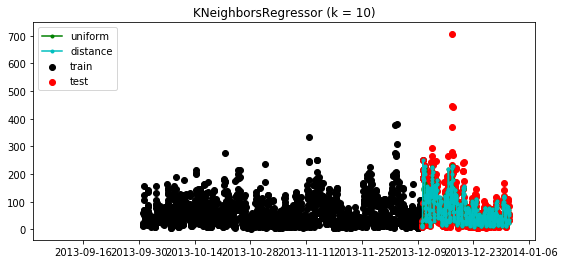

In [4]:
asdf = '2013-12-10'
end = '2013-10-01'
x_train = lagged[end:asdf].interpolate()
y_train = df.loc['DESN025'].Concentration.NO[end:asdf]
index_train = df.loc['DESN025'].Concentration.NO[end:asdf].index.values

x_test = lagged[asdf:].iloc[:-1]
y_test = df.loc['DESN025'].Concentration.NO[asdf:]
index_test = df.loc['DESN025'].Concentration.NO[asdf:].index.values


# plt.figure(figsize=(20,10))
# #############################################################################
# Fit regression model
n_neighbors = 10

plt.figure(figsize=(9, 4))
plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c']
solutions = {}

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn_model = knn.fit(x_train, y_train)
    y_ = knn_model.predict(x_test)
    solutions['knn %s' % weights] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label=weights)
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i)" % (n_neighbors))
    print('{0} mae: {1}\tmse: {2}'.format(weights, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

<IPython.core.display.Javascript object>


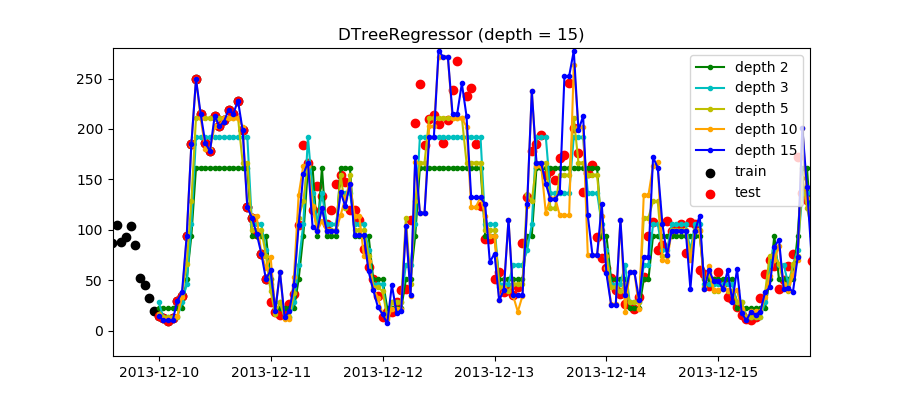

2 mae: 24.376921168547387	mse: 1919.0991674122222
3 mae: 21.818967498735116	mse: 1603.9852568583826
5 mae: 20.88424014764349	mse: 1559.2339940350207
10 mae: 25.208116224007046	mse: 1999.9387812320208
15 mae: 24.929234097278318	mse: 1956.607156923221


In [24]:
asdf = '2013-12-10'
end = '2013-10-01'
x_train = lagged[end:asdf].interpolate()
y_train = df.loc['DESN025'].Concentration.NO[end:asdf]
index_train = df.loc['DESN025'].Concentration.NO[end:asdf].index.values

x_test = lagged[asdf:].iloc[:-1]
y_test = df.loc['DESN025'].Concentration.NO[asdf:]
index_test = df.loc['DESN025'].Concentration.NO[asdf:].index.values

plt.figure(figsize=(9, 4))
plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']

########################################################################
for i, depth in enumerate([2, 3, 5, 10, 15]):
    dtree = tree.DecisionTreeRegressor(max_depth=depth)
    dtree_model = dtree.fit(x_train, y_train)
    y_ = dtree_model.predict(x_test)
    solutions['dtree depth %s' % depth] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label='depth {0}'.format(depth))
    plt.axis('tight')
    plt.legend()
    plt.title("DTreeRegressor (depth = {0})".format(depth))
    print('{0} mae: {1}\tmse: {2}'.format(depth, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))